In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random as rn
import string
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import matplotlib.image as mpimg
from nltk.translate.bleu_score import sentence_bleu
import pickle

In [2]:
tf.version.VERSION

'2.2.0'

In [3]:
test_images = np.load("test_img.npy",allow_pickle=True)
test_actual = np.load("test_actual.npy",allow_pickle=True)

In [5]:
test_images[0], test_actual[0]

(array(['CXR2978_IM-1367-4001.png', 'CXR2978_IM-1367-1001.png'],
       dtype=object), '<start> no acute findings <end>')

In [4]:
#Unzip the uploaded files, folder names are same for zip file name
tokenizer = pickle.load(open("tokenizer.pkl", 'rb'))
decoder = tf.saved_model.load('decoder/')
encoder = tf.saved_model.load('encoder/')

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import os
image_features_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
image_features_model.load_weights("trained_weights-07-0.9102.hdf5")

In [11]:
#Provide image path
image_path = "img/"

In [13]:
max_len_output =80
units = 128

In [15]:
def get_img_tensor(image_path, img_name, model_image):
    img = tf.io.read_file(image_path + str(img_name))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    img_features = model_image(tf.constant(img)[None, :])
    return img_features

In [ ]:
#ref: https://yashk2810.github.io/Image-Captioning-using-InceptionV3-and-Beam-Search/
#https://www.geeksforgeeks.org/sorted-function-python/

def calculate_score(x):
    """Calculates the cumulative score for the length of sentence"""
    return x[1]/len(x[0])

def final_fun_1(img_name, beam_index = 3):
    """Beam search implementaion takes images as input"""
    hidden =  tf.zeros((1, units))
    img_tensor = tf.convert_to_tensor([get_img_tensor("img/",img_name[0], image_features_model), 
                                      get_img_tensor("img/",img_name[1], image_features_model)])
    img_features = tf.constant(img_tensor)[None, :]
    features_val = encoder(img_features)
    start = [tokenizer.word_index["<start>"]]
    dec_word = [[start, 0.0]]
    while len(dec_word[0][0]) < max_len_output:
        temp = []
        for s in dec_word:
            predictions, hidden = decoder([tf.cast(tf.expand_dims([s[0][-1]], 0), tf.float32), features_val, hidden])

            word_preds = np.argsort(predictions[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += predictions[0][w]
                temp.append([next_cap, prob.numpy()])
        dec_word = temp
        # Sorting according to the probabilities scores
        dec_word = sorted(dec_word, reverse=False, key=calculate_score)
        # Getting the top words
        dec_word = dec_word[-beam_index:]
    dec_word = dec_word[-1][0]
    impression = [tokenizer.index_word[i] for i in dec_word if i !=0]
    result = []
    
    for i in impression:
        if i != '<end>':
            result.append(i)
        else:
            break
    
    text = ' '.join(result[1:])
    return result, text

In [50]:
def argmax_search(img_names):
    """Displays images for given input array of image names"""
    fig, axs = plt.subplots(1, len(img_names), figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_names, axs.flatten()):
        img_=mpimg.imread(image_path+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()
    hidden =  tf.zeros((1, units))
    img_tensor = tf.convert_to_tensor([get_img_tensor(image_path,img_names[0], image_features_model), 
                                      get_img_tensor(image_path,img_names[1], image_features_model)])
    img_features = tf.constant(img_tensor)[None,:]
    features_val = encoder(img_features)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    text = ""
    for i in range(max_len_output):
        predictions, hidden = decoder([tf.cast(dec_input, tf.float32),features_val,hidden])
        predicted_id = tf.argmax(predictions, axis=1)[0].numpy()
        if predicted_id !=0:
            word = tokenizer.index_word[predicted_id]
        else:
            word = ""
        result.append(word)
        text += " " + word
        if word == '<end>' or word == 'end':
            return result, text

        dec_input = tf.expand_dims([predicted_id], 0)
    return result, text

In [51]:
def final_fun_2(result, text, actual_text):
    """Find Bleu Score"""
    reference = [actual_text.split()[1:-1]]
    result = result[:-1]
    print("="*50)
    print("Actual", actual_text)
    print("Predicted:",text)
    print("="*50)
    print('Individual 1-gram: {:.4f} Cumulative 1-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(1, 0, 0, 0)), sentence_bleu(reference, result, weights=(1, 0, 0, 0))))
    print('Individual 2-gram: {:.4f} Cumulative 2-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 1, 0, 0)), sentence_bleu(reference, result, weights=(0.5, 0.5, 0, 0))))
    print('Individual 3-gram: {:.4f} Cumulative 3-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 1, 0)), sentence_bleu(reference, result, weights=(0.33, 0.33, 0.33, 0))))
    print('Individual 4-gram: {:.4f} Cumulative 4-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 0, 1)), sentence_bleu(reference, result, weights=(0.25, 0.25, 0.25, 0.25))))

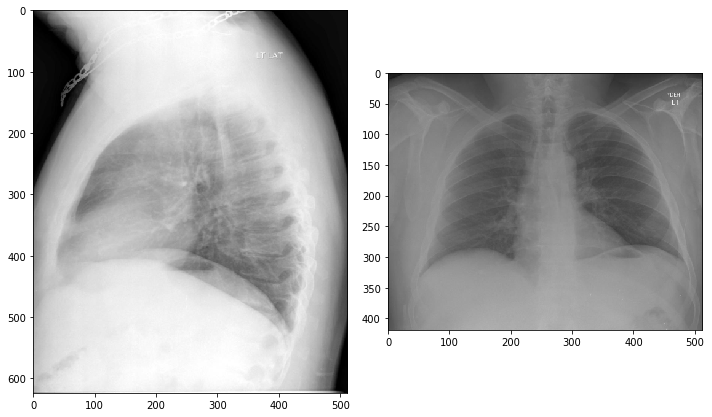

Actual <start> no acute cardiopulmonary findings <end>
Predicted:  no acute cardiopulmonary findings specifically no acute pulmonary disease <end>
Individual 1-gram: 0.4444 Cumulative 1-gram: 0.4444
Individual 2-gram: 0.3750 Cumulative 2-gram: 0.4082
Individual 3-gram: 0.2857 Cumulative 3-gram: 0.3662
Individual 4-gram: 0.1667 Cumulative 4-gram: 0.2985


In [52]:
result, text_predicted = final_fun_1(test_images[108])
actual = test_actual[108]
final_fun_2(result,text_predicted,actual)